###  Simulate `build_gaussian_tf` function 
- Setup model, load weights and data generators 
- get items from data generator
- pass through network

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
import random
import math
import re
import  gc
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

import keras.backend as KB
sys.path.append('../')

import mrcnn.model     as modellib
import mrcnn.visualize as visualize
import mrcnn.shapes    as shapes
from mrcnn.config      import Config
from mrcnn.model       import log
from mrcnn.dataset     import Dataset 

from mrcnn.utils       import stack_tensors, stack_tensors_3d
from mrcnn.datagen     import data_generator, load_image_gt
from mrcnn.callbacks   import get_layer_output_1,get_layer_output_2
from mrcnn.visualize   import plot_gaussian
# from mrcnn.pc_layer    import PCTensor
# from mrcnn.pc_layer   import PCNLayer

# Root directory of the project
ROOT_DIR = os.getcwd()
MODEL_PATH = 'E:\Models'
# Directory to save logs and trained model
MODEL_DIR = os.path.join(MODEL_PATH, "mrcnn_logs")
# Path to COCO trained weights
COCO_MODEL_PATH   = os.path.join(MODEL_PATH, "mask_rcnn_coco.h5")
RESNET_MODEL_PATH = os.path.join(MODEL_PATH, "resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

print("Tensorflow Version: {}   Keras Version : {} ".format(tf.__version__,keras.__version__))
import pprint
pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4)


# Build configuration object -----------------------------------------------
config = shapes.ShapesConfig()
config.BATCH_SIZE      = 3                  # Batch size is 2 (# GPUs * images/GPU).
config.IMAGES_PER_GPU  = 3                  # Must match BATCH_SIZE
config.STEPS_PER_EPOCH = 2
config.FCN_INPUT_SHAPE = config.IMAGE_SHAPE[0:2]
# config.display() 

# Build shape dataset        -----------------------------------------------
# Training dataset
# generate 500 shapes 
dataset_train = shapes.ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = shapes.ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

try :
    del model, train_generator, val_generator, mm
    gc.collect()
except: 
    pass
# Load and display random samples
# image_ids = np.random.choice(dataset_train.image_ids, 3)
# for image_id in [3]:
#     image = dataset_train.load_image(image_id)
#     mask, class_ids = dataset_train.load_mask(image_id)
#     visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
print(' COCO Model Path       : ', COCO_MODEL_PATH)
print(' Checkpoint folder Path: ', MODEL_DIR)
print(MODEL_PATH)
print(COCO_MODEL_PATH)
print(RESNET_MODEL_PATH)
print(MODEL_DIR)


np.set_printoptions(linewidth=100, precision=4)


batch_size = 3
num_rois = 32
num_classes = 4
num_detections = 100
num_rois_per_image = 32
rois_per_image = 32

try :
    del model
    print('delete model is successful')
    gc.collect()
except: 
    pass

# tf.reset_default_graph()
# KB.clear_session()
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Tensorflow Version: 1.6.0   Keras Version : 2.1.4 
 Initialize config object - super
 COCO Model Path       :  E:\Models\mask_rcnn_coco.h5
 Checkpoint folder Path:  E:\Models\mrcnn_logs
E:\Models
E:\Models\mask_rcnn_coco.h5
E:\Models\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
E:\Models\mrcnn_logs
    set_log_dir: Checkpoint path set to : E:\Models\mrcnn_logs\shapes20180504T1855\mask_rcnn_shapes_{epoch:04d}.h5
    set_log_dir: self.epoch set to 0 

>>> Resnet Graph 
     Input_image shape : (?, 128, 128, 3)
     After ZeroPadding2D  : (?, 134, 134, 3) (?, 134, 134, 3)
     After Conv2D padding : (?, 64, 64, 64) (?, 64, 64, 64)
     After BatchNorm      : (?, 64, 64, 64) (?, 64, 64, 64)
     After MaxPooling2D   : (?, 32, 32, 64) (?, 32, 32, 64)

>>> Feature Pyramid Network (FPN) Graph 
     FPN P2 shape : (None, 32, 32, 256)
     FPN P3 shape : (None, 16, 16, 256)
     FPN P4 shape : (None, 8, 8, 256)
     FPN P5 shape : (None, 4, 4, 256)
     FPN P6 shape : (None, 2, 2, 256)


    >> input to MVN.PROB: pos_grid (meshgrid) shape:  (128, 128, 3, 100, 2)
    << output probabilities shape: (3, 100, 128, 128)

    Scatter out the probability distributions based on class --------------
    gaussian_grid      :  (3, 100, 128, 128)
    class shape        :  (3, ?)
    roi_grid shape     :  (3, 100)
    batch_grid shape   :  (3, 100)
    scatter_classes    :  (3, 100, 3)
    gaussian scattered :  (3, 4, 100, 128, 128)

    Reduce sum based on class ---------------------------------------------
    gaussian sum type/name :  <class 'tensorflow.python.framework.ops.Tensor'> cntxt_layer/gt_gaussian:0 gt_gaussian
    gaussian_sum shape     :  (3, 128, 128, 4) Keras tensor  False

    Output build_gaussian_tf 
     pred_gaussian :  (3, 128, 128, 4) Keras tensor  False
     gt_gaussian   :  (3, 128, 128, 4) Keras tensor  False
<<<  shape of pred_gaussian   :  (3, 128, 128, 4)  Keras tensor  True
<<<  shape of gt_gaussian     :  (3, 128, 128, 4)  Keras tensor  True

>>> rpn_

In [2]:
print(model.find_last())
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
#     loc=model.load_weights(model.get_imagenet_weights(), by_name=True)
    loc=model.load_weights(RESNET_MODEL_PATH, by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    
    # See README for instructions to download the COCO weights
    loc=model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    loc= model.load_weights(model.find_last()[1], by_name=True)
print('Load weights complete')

train_generator = data_generator(dataset_train, model.config, shuffle=True,
                                 batch_size=model.config.BATCH_SIZE,
                                 augment = False)
val_generator = data_generator(dataset_val, model.config, shuffle=True, 
                                batch_size=model.config.BATCH_SIZE,
                                augment=False)

print('\n Outputs: ') 
for i, out in enumerate(model.keras_model.outputs):
    print(i , '    ', out)


('E:\\Models\\mrcnn_logs\\shapes20180428T1819', 'E:\\Models\\mrcnn_logs\\shapes20180428T1819\\mask_rcnn_shapes_5784.h5')
>>> load_weights()
    load_weights: Loading weights from: E:\Models\mrcnn_logs\shapes20180428T1819\mask_rcnn_shapes_5784.h5
    load_weights: Log directory set to : E:\Models\mrcnn_logs\shapes20180428T1819\mask_rcnn_shapes_5784.h5
    set_log_dir: Checkpoint path set to : E:\Models\mrcnn_logs\shapes20180428T1819\mask_rcnn_shapes_{epoch:04d}.h5
    set_log_dir: self.epoch set to 5785 
    Load weights complete :  E:\Models\mrcnn_logs\shapes20180428T1819\mask_rcnn_shapes_5784.h5
Load weights complete

 Outputs: 
0      Tensor("rpn_class_logits/concat:0", shape=(?, ?, 2), dtype=float32)
1      Tensor("rpn_class/concat:0", shape=(?, ?, 2), dtype=float32)
2      Tensor("rpn_bbox/concat:0", shape=(?, ?, 4), dtype=float32)
3      Tensor("rpn_proposal_rois/packed_2:0", shape=(3, ?, ?), dtype=float32)
4      Tensor("proposal_targets/output_rois:0", shape=(3, ?, ?), dtype=flo

In [ ]:
# print('\n Outputs: ') 
# for i, out in enumerate(model.keras_model.outputs):
#     print(i , '    ', out)


In [3]:
train_batch_x, train_batch_y = next(train_generator)

Image id:  462
Image meta [462 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [3 2 2]


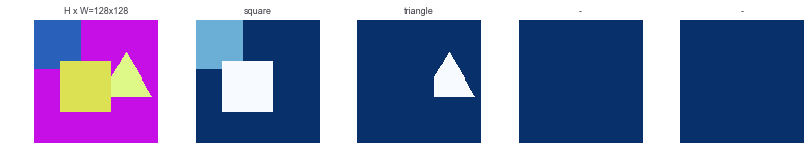

Image id:  288
Image meta [288 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [1 1]


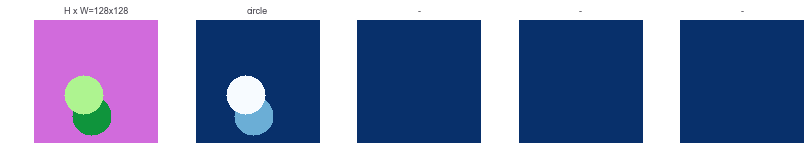

Image id:  306
Image meta [306 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [3]


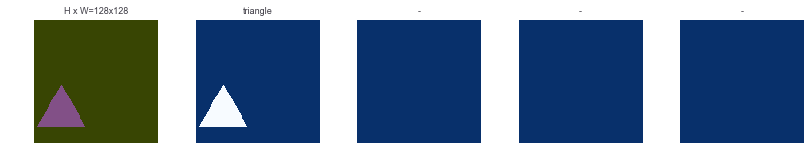

In [4]:
# train_batch_x, train_batch_y = next(train_generator)
imgmeta_idx = model.keras_model.input_names.index('input_image_meta')
img_meta    = train_batch_x[imgmeta_idx]

for img_idx in range(config.BATCH_SIZE):
    image_id = img_meta[img_idx,0]
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print('Image id: ',image_id)
    print('Image meta', img_meta[img_idx])
    print('Classes (1: circle, 2: square, 3: triangle ): ',class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [5]:

model_output = get_layer_output_2(model.keras_model, train_batch_x, 1)


/* Inputs */
Input  0:  (input_image:0                           ) 	  Input shape: (3, 128, 128, 3)
Input  1:  (input_image_meta:0                      ) 	  Input shape: (3, 12)
Input  2:  (input_rpn_match:0                       ) 	  Input shape: (3, 4092, 1)
Input  3:  (input_rpn_bbox:0                        ) 	  Input shape: (3, 256, 4)
Input  4:  (input_gt_class_ids:0                    ) 	  Input shape: (3, 100)
Input  5:  (input_gt_boxes:0                        ) 	  Input shape: (3, 100, 4)
Input  6:  (input_gt_masks:0                        ) 	  Input shape: (3, 56, 56, 100)
<class 'list'>

/* Outputs */
Output  0: (rpn_class_logits/concat:0               ) 	  Output shape: (3, 4092, 2)
Output  1: (rpn_class/concat:0                      ) 	  Output shape: (3, 4092, 2)
Output  2: (rpn_bbox/concat:0                       ) 	  Output shape: (3, 4092, 4)
Output  3: (rpn_proposal_rois/packed_2:0            ) 	  Output shape: (3, 2000, 4)
Output  4: (proposal_targets/output_rois:0 

In [10]:
# KB.clear_session()
KB.clear_session()
sess = tf.InteractiveSession()
KB.set_session(sess)
print(sess)
print(len(model_output))

22


###  Extract input parms to `build_pred_tf()`

In [15]:
mrcnn_class = KB.constant(model_output[10])
mrcnn_bbox  = KB.constant(model_output[11])
output_rois = KB.constant(model_output[4])
input_image        = KB.constant(train_batch_x[0])
input_gt_class_ids = KB.constant(train_batch_x[4])
input_gt_boxes     = KB.constant(train_batch_x[5])
print(input_image.shape)
h, w = KB.shape(input_image)[1], KB.shape(input_image)[2]
image_scale = KB.cast(KB.stack([h, w, h, w], axis=0), tf.float32)

input_normlzd_gt_boxes =  input_gt_boxes / image_scale

pred_tensor = KB.constant(model_output[20])

(3, 128, 128, 3)


In [16]:
# print(input_gt_boxes[0].eval())
# print(input_normlzd_gt_boxes[0].eval())
print(pred_tensor[0].eval())

[[[  0.         0.         0.         0.         0.         0.999996]
  [  0.         0.         0.         0.         0.         0.999996]
  [ 85.53507   57.621796 128.       101.088135   0.         0.999995]
  [ 76.024704   0.       128.        60.0402     0.         0.999982]
  [ 13.289261  65.24481   62.54151  113.18568    0.         0.999974]
  [ 22.103733  75.61586   50.462715 103.19139    0.         0.999942]
  [ 21.93049   72.280685  56.9629   105.66049    0.         0.999915]
  [  0.         0.        94.127884 128.         0.         0.999888]
  [ 25.06613   65.813965  60.284325  99.44057    0.         0.999874]
  [  3.208536  27.019587  51.526016  72.50126    0.         0.999793]
  [ 72.223274  76.13063  126.47227  121.77056    0.         0.999707]
  [ 19.160496   0.        80.75029   42.71232    0.         0.999678]
  [ 37.764294   0.       128.        55.171047   0.         0.999625]
  [  0.        56.657253  51.620148 128.         0.         0.999528]
  [  7.62859   33.03


###  Display for visual check - `pred_tensor` is the final result which is passed on to  `build_gaussian_tf()`

In [18]:
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_tensor shape is ', pred_tensor.get_shape() )
img = 0
print('Image ', img , '/ Class 0 ------------')
print(pred_tensor[img,0].eval())
print('Image ', img , '/ Class 1 ------------')
print(pred_tensor[img,1].eval())
print('Image ', img , '/ Class 2 ------------')
print(pred_tensor[img,2].eval())
print('Image ', img , '/ Class 3 ------------')
print(pred_tensor[img,3].eval())
 
# cls = 3
# print('Image 0 / Class ', cls ,' ------------')
# print(pred_tensor[0, cls].eval())
# print('Image 1 / Class ', cls ,' ------------')
# print(pred_tensor[1, cls].eval())
# print('Image 2 / Class ', cls ,' ------------')
# print(pred_tensor[2, cls].eval())



# print(pred_tensor_out.shape)
# print(pred_tensor_out[2,2, :].eval())
# print(pred_tensor.shape)
# pred_tensor_tst = pred_tensor *[128, 128, 128,128,1,1]
# print(pred_tensor_tst[2,2,:].eval())

pred_tensor shape is  (3, 4, 32, 6)
Image  0 / Class 0 ------------
[[  0.         0.         0.         0.         0.         0.999996]
 [  0.         0.         0.         0.         0.         0.999996]
 [ 85.53507   57.621796 128.       101.088135   0.         0.999995]
 [ 76.024704   0.       128.        60.0402     0.         0.999982]
 [ 13.289261  65.24481   62.54151  113.18568    0.         0.999974]
 [ 22.103733  75.61586   50.462715 103.19139    0.         0.999942]
 [ 21.93049   72.280685  56.9629   105.66049    0.         0.999915]
 [  0.         0.        94.127884 128.         0.         0.999888]
 [ 25.06613   65.813965  60.284325  99.44057    0.         0.999874]
 [  3.208536  27.019587  51.526016  72.50126    0.         0.999793]
 [ 72.223274  76.13063  126.47227  121.77056    0.         0.999707]
 [ 19.160496   0.        80.75029   42.71232    0.         0.999678]
 [ 37.764294   0.       128.        55.171047   0.         0.999625]
 [  0.        56.657253  51.620148 

##  `build_pred_tf ()` 

###  Build Pred_Tensor

`pred_tensor[:,:,:,1:7]`  == `[116.9736  21.8213  36.2715  45.6026   0.    0.9139   ]`


Detections returned by `detect()` routine:

`[[ 25.          18.          80.          72.           2.           0.99936014]
  [ 51.           3.         106.          71.           3.           0.99924326]`

In [ ]:
def build_predictions_tf(mrcnn_class, mrcnn_bbox, norm_output_rois, config):
    # // pass model to TensorBuilder
    batch_size      = config.BATCH_SIZE
    num_classes     = config.NUM_CLASSES
    h, w            = config.IMAGE_SHAPE[:2]
    # num_rois        = config.TRAIN_ROIS_PER_IMAGE
    num_cols        = 6
    num_rois        = KB.int_shape(norm_output_rois)[1]
    output_rois = norm_output_rois * np.array([h,w,h,w])   

    print()
    print('  > BUILD_PREDICTIONS_TF()')
    print('    num_rois          : ', num_rois )
    print('    mrcnn_class shape : ', KB.shape(mrcnn_class), KB.int_shape(mrcnn_class))
    print('    mrcnn_bbox.shape  : ', KB.shape(mrcnn_bbox), KB.int_shape(mrcnn_bbox), mrcnn_bbox.shape )
    print('    output_rois.shape : ', KB.shape(output_rois), KB.int_shape(output_rois))
    #---------------------------------------------------------------------------
    # use the argmaxof each row to determine the dominating (predicted) class
    #---------------------------------------------------------------------------
    pred_classes     = tf.to_int32(tf.argmax( mrcnn_class,axis=-1))
    pred_classes_exp = tf.to_float(tf.expand_dims(pred_classes ,axis=-1))
    pred_scores      = tf.reduce_max(mrcnn_class ,axis=-1, keepdims=True)   # (32,)
    
    # np.set_printoptions(linewidth=100, precision=4)
    # print('    pred_classes with highest scores:', pred_classes.get_shape() )
    # pred_scores_exp = tf.to_float(tf.expand_dims(pred_scores, axis=-1))
    # print('    pred_ scores:', pred_scores.get_shape())
    
    print('    pred_classes     : ', pred_classes.shape)
    print('    pred_classes_exp : ', pred_classes_exp.shape)
    print('    pred_scores      : ', pred_scores.shape)
    

    batch_grid, roi_grid = tf.meshgrid( tf.range(batch_size, dtype=tf.int32),
                                        tf.range(num_rois, dtype=tf.int32), indexing = 'ij' )
    bbox_idx             = tf.to_float(tf.expand_dims(roi_grid , axis = -1))    
    
    print('    batch_grid       : ', batch_grid.shape)
    print('    roi_grid         : ', roi_grid.shape)
    print('    bbox_idx         : ', bbox_idx.shape)
    # print(roi_grid.eval())
    # print(batch_grid.eval())

    #-----------------------------------------------------------------------------------
    # This part is used if we want to gather bbox coordinates from mrcnn_bbox 
    #  Currently we are gathering bbox coordinates form output_roi so we dont need this
    #-----------------------------------------------------------------------------------
    # bbox_selected    = tf.zeros_like(norm_output_rois)
    # print('    bbox_selected    : ', bbox_selected.shape)
    # gather_boxes    = tf.stack([batch_grid, roi_grid, pred_classes, ], axis = -1)
    # print('-- gather_boxes  ----')
    # print('gather_boxes inds', type(gather_boxes), 'shape',tf.shape(gather_boxes).eval())
    # print(gather_boxes.eval())
    # bbox_selected   = tf.gather_nd(mrcnn_bbox, gather_boxes)
    # print('    bbox_selected shape : ', bbox_selected.get_shape())
    # print(bbox_selected[0].eval())    
    #-----------------------------------------------------------------------------------
    
    ## moved pred_scores to end -- 30-04-2018
    print('\n    -- pred_tensor tf ------------------------------') 
    # pred_array  = tf.concat([bbox_idx , output_rois, pred_classes_exp , pred_scores], axis=-1)
    pred_array  = tf.concat([ output_rois, pred_classes_exp , pred_scores], axis=-1)
    print('    pred_array shape:', pred_array.shape)
    
    # pred_array = pred_array[~np.all(pred_array[:,:,2:6] == 0, axis=1)]    
    # class_ids = tf.to_int32(pred_array[:,:,6])
    # print('    class shape: ', class_ids.get_shape())
    # print(class_ids.eval())


    scatter_ind          = tf.stack([batch_grid , pred_classes, roi_grid],axis = -1)
    pred_scatt = tf.scatter_nd(scatter_ind, pred_array, [batch_size, num_classes, num_rois, num_cols])
    # print('scatter_ind', type(scatter_ind), 'shape',tf.shape(scatter_ind).eval())
    print('    pred_scatter shape is ', pred_scatt.get_shape(), pred_scatt)
    
    #------------------------------------------------------------------------------------
    ## sort pred_scatter in each class dimension based on prediction score (last column)
    #------------------------------------------------------------------------------------
    # _, sort_inds = tf.nn.top_k(pred_scatt[:,:,:,1], k=pred_scatt.shape[2])   <-- moved score to last column 30-4-2018
    _, sort_inds = tf.nn.top_k(pred_scatt[:,:,:,-1], k=pred_scatt.shape[2])
    print('    sort inds shape : ', sort_inds.get_shape())

    # build indexes to gather rows from pred_scatter based on sort order 
    
    class_grid, batch_grid, roi_grid = tf.meshgrid(tf.range(num_classes),tf.range(batch_size), tf.range(num_rois))
    roi_grid_exp = tf.to_float(tf.expand_dims(roi_grid, axis = -1))
    
    gather_inds  = tf.stack([batch_grid , class_grid, sort_inds],axis = -1)
    pred_tensor  = tf.gather_nd(pred_scatt, gather_inds, name = 'pred_tensor')
    
    print('    class_grid  ', type(class_grid) , 'shape', class_grid.get_shape())
    print('    batch_grid  ', type(batch_grid) , 'shape', batch_grid.get_shape())
    print('    roi_grid shape', roi_grid.get_shape(), 'roi_grid_exp shape ', roi_grid_exp.get_shape())
    print('    gather_inds ', type(gather_inds), 'shape', gather_inds.get_shape())
    print('    pred_tensor (gathered)  : ', pred_tensor.get_shape())

    # append an index to the end of each row --- commented out 30-04-2018
    # pred_tensor  = tf.concat([pred_tensor, roi_grid_exp], axis = -1)
    
    # count based on pred score > 0 (changed from index 0 to -1 on 30-04-2018)
    pred_cls_cnt = tf.count_nonzero(pred_tensor[:,:,:,-1], axis = -1, name = 'pred_cls_count')
    
    print('    -- pred_tensor results (bboxes sorted by score) ----')    
    print('    final pred_tensor shape  : ', pred_tensor.get_shape())
    print('    final pred_cls_cnt shape : ',pred_cls_cnt.get_shape())
    print('    complete')

    return  [pred_tensor, pred_cls_cnt] 
    

In [ ]:
 pred_tensor , pred_cls_cnt  = build_predictions_tf(mrcnn_class, mrcnn_bbox, output_rois, model.config)

### Copy of `build_gaussian_tf()`

In [ ]:
def development_build_predictions_tf(mrcnn_class, mrcnn_bbox, norm_output_rois, config):
    # // pass model to TensorBuilder
    batch_size      = config.BATCH_SIZE
    num_classes     = config.NUM_CLASSES
    h, w            = config.IMAGE_SHAPE[:2]
    # num_rois        = config.TRAIN_ROIS_PER_IMAGE
    num_cols        = 6
    num_rois        = KB.int_shape(norm_output_rois)[1]
    output_rois = norm_output_rois * np.array([h,w,h,w])   

    print()
    print('  > BUILD_PREDICTIONS_TF()')
    print('    num_rois          : ', num_rois )
    print('    mrcnn_class shape : ', KB.shape(mrcnn_class), KB.int_shape(mrcnn_class))
    print('    mrcnn_bbox.shape  : ', KB.shape(mrcnn_bbox), KB.int_shape(mrcnn_bbox), mrcnn_bbox.shape )
    print('    output_rois.shape : ', KB.shape(output_rois), KB.int_shape(output_rois))
    #---------------------------------------------------------------------------
    # use the argmaxof each row to determine the dominating (predicted) class
    #---------------------------------------------------------------------------
    pred_classes     = tf.to_int32(tf.argmax( mrcnn_class,axis=-1))
    pred_classes_exp = tf.to_float(tf.expand_dims(pred_classes ,axis=-1))
    pred_scores      = tf.reduce_max(mrcnn_class ,axis=-1, keepdims=True)   # (32,)   
    pred_scores_exp  = tf.to_float(tf.expand_dims(pred_scores, axis=-1))
    np.set_printoptions(linewidth=100, precision=4)
    
    print('    pred_classes with highest scores:', pred_classes.get_shape() )
#   print('    pred_ scores:', pred_scores.eval())
    
    print('    pred_classes     : ', pred_classes.shape)
    print('    pred_classes_exp : ', pred_classes_exp.shape)
    print('    pred_scores      : ', pred_scores.shape)
    
    _temp = tf.stack([tf.to_float(pred_classes), tf.squeeze(pred_scores)],axis = -1)
    print(_temp.shape)
    print(_temp[0].eval())
    
    batch_grid, roi_grid = tf.meshgrid( tf.range(batch_size, dtype=tf.int32),
                                        tf.range(num_rois, dtype=tf.int32), indexing = 'ij' )
    bbox_idx             = tf.to_float(tf.expand_dims(roi_grid , axis = -1))    
    
    print('    batch_grid       : ', batch_grid.shape)
    print('    roi_grid         : ', roi_grid.shape)
    print('    bbox_idx         : ', bbox_idx.shape)
    # print(roi_grid.eval())
    # print(batch_grid.eval())

    #-----------------------------------------------------------------------------------
    # This part is used if we want to gather bbox coordinates from mrcnn_bbox 
    #  Currently we are gathering bbox coordinates form output_roi so we dont need this
    #-----------------------------------------------------------------------------------
    # bbox_selected    = tf.zeros_like(norm_output_rois)
    # print('    bbox_selected    : ', bbox_selected.shape)
    # gather_boxes    = tf.stack([batch_grid, roi_grid, pred_classes, ], axis = -1)
    # print('-- gather_boxes  ----')
    # print('gather_boxes inds', type(gather_boxes), 'shape',tf.shape(gather_boxes).eval())
    # print(gather_boxes.eval())
    # bbox_selected   = tf.gather_nd(mrcnn_bbox, gather_boxes)
    # print('    bbox_selected shape : ', bbox_selected.get_shape())
    # print(bbox_selected[0].eval())    
    #-----------------------------------------------------------------------------------
    
    ## moved pred_scores to end -- 30-04-2018
    print('\n    -- pred_tensor tf ------------------------------') 
    # pred_array  = tf.concat([bbox_idx , output_rois, pred_classes_exp , pred_scores], axis=-1)
    pred_array  = tf.concat([ output_rois, pred_classes_exp , pred_scores], axis=-1)
    print('    pred_array shape:', pred_array.shape)
    
    # pred_array = pred_array[~np.all(pred_array[:,:,2:6] == 0, axis=1)]    
    # class_ids = tf.to_int32(pred_array[:,:,6])
    # print('    class shape: ', class_ids.get_shape())
    # print(class_ids.eval())


    scatter_ind          = tf.stack([batch_grid , pred_classes, roi_grid],axis = -1)
    pred_scatt = tf.scatter_nd(scatter_ind, pred_array, [batch_size, num_classes, num_rois, num_cols])
    # print('scatter_ind', type(scatter_ind), 'shape',tf.shape(scatter_ind).eval())
    print('    pred_scatter shape is ', pred_scatt.get_shape(), pred_scatt)
    
    #------------------------------------------------------------------------------------
    ## sort pred_scatter in each class dimension based on prediction score (last column)
    #------------------------------------------------------------------------------------
    # _, sort_inds = tf.nn.top_k(pred_scatt[:,:,:,1], k=pred_scatt.shape[2])   <-- moved score to last column 30-4-2018
    _, sort_inds = tf.nn.top_k(pred_scatt[:,:,:,-1], k=pred_scatt.shape[2])
    print('    sort inds shape : ', sort_inds.get_shape())

    # build indexes to gather rows from pred_scatter based on sort order 
    
    class_grid, batch_grid, roi_grid = tf.meshgrid(tf.range(num_classes),tf.range(batch_size), tf.range(num_rois))
    roi_grid_exp = tf.to_float(tf.expand_dims(roi_grid, axis = -1))
    
    gather_inds  = tf.stack([batch_grid , class_grid, sort_inds],axis = -1)
    pred_tensor  = tf.gather_nd(pred_scatt, gather_inds, name = 'pred_tensor')
    
    print('    class_grid  ', type(class_grid) , 'shape', class_grid.get_shape())
    print('    batch_grid  ', type(batch_grid) , 'shape', batch_grid.get_shape())
    print('    roi_grid shape', roi_grid.get_shape(), 'roi_grid_exp shape ', roi_grid_exp.get_shape())
    print('    gather_inds ', type(gather_inds), 'shape', gather_inds.get_shape())
    print('    pred_tensor (gathered)  : ', pred_tensor.get_shape())

    # append an index to the end of each row --- commented out 30-04-2018
    # pred_tensor  = tf.concat([pred_tensor, roi_grid_exp], axis = -1)
    
    # count based on pred score > 0 (changed from index 0 to -1 on 30-04-2018)
    pred_cls_cnt = tf.count_nonzero(pred_tensor[:,:,:,-1], axis = -1, name = 'pred_cls_count')
    
    print('    -- pred_tensor results (bboxes sorted by score) ----')    
    print('    final pred_tensor shape  : ', pred_tensor.get_shape())
    print('    final pred_cls_cnt shape : ',pred_cls_cnt.get_shape())
    print('    complete')

    return  [pred_tensor, pred_cls_cnt] 
    

In [ ]:
 pred_tensor2 , pred_cls_cnt2  = development_build_predictions_tf(mrcnn_class, mrcnn_bbox, output_rois, model.config)

###  Test `means`, `covar`, `gauss_grid`, and `gauss_sum ` between development version and final version

In [ ]:
print(pred_tensor.get_shape(), pred_tensor2.get_shape())
print(np.all(pred_tensor.eval() == pred_tensor2.eval()))
# tst1 = means.eval()
# tst2 = means2.eval()
# print(tst1.shape, tst2.shape)

# print(tst1[0,:10])
# print()
# print(tst2[0,:10])
# print(np.all(tst1 == tst2))
# print()
# del tst1, tst2

In [ ]:
tst1 = pred_tensor.eval()
tst2 = pred_tensor2.eval()

In [ ]:
print(tst1[0])

In [ ]:
print(output_rois.eval())

### Compute min and max of `gauss_sum()`

In [ ]:
print(gauss_sum.shape)
for img in [0,1,2]:
    for cls in range(4):
        gauss_mean = KB.mean(gauss_sum[img,:,:,cls]).eval()
        gauss_min  =  KB.min(gauss_sum[img, :,:,cls]).eval()
        gauss_max  =  KB.max(gauss_sum[img, :,:,cls]).eval()
        print('Img/bbx: ', img, '/',cls ,'   Mean: ', gauss_mean, '\t Max: ' , gauss_max, '\t Min :', gauss_min)

In [ ]:
pred_gauss = tf.constant(layers_out[19])
print(pred_gauss.shape)
for img in [0,1,2]:
    for cls in range(4):
        gauss_mean = KB.mean(pred_gauss[img,:,:,cls]).eval()
        gauss_min  = KB.min(pred_gauss[img, :,:,cls]).eval()
        gauss_max  = KB.max(pred_gauss[img, :,:,cls]).eval()
        print('Img/bbx: ', img, '/',cls ,'   Mean: ', gauss_mean, '\t Max: ' , gauss_max, '\t Min :', gauss_min)


## Plot Predicted and Ground Truth Probability Heatmaps `pred_gaussian` and `gt_gaussian` (Tensorflow)

`pred_gaussian2` and `gt_gaussian2` from Tensorflow PCN layer

In [ ]:
%matplotlib notebook
# gt_heatmap  = layers_out[27]     # gt_gaussiam 
# pred_heatmap= layers_out[24]  # pred_gaussian
gt_heatmap  = layers_out[19]     # gt_gaussiam 
pred_heatmap= layers_out[18]  # pred_gaussian
print('gt_gaussian heatmap shape : ', gt_heatmap.shape, ' pred_gaussian heatmap shape: ', pred_heatmap.shape)
num_images = 1 # config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES

img = 0

image_id = img_meta[img,0]
print('Image id: ',image_id)
print('Classes (1: circle, 2: square, 3: triangle ): ')
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


for cls in range(1,num_classes):
    ttl = 'GROUND TRUTH HEATMAP - image :  {} class: {} '.format(img,cls)
    print(' *** Zout  ', gt_heatmap[img,:,:,cls].shape, ttl)   
    plot_gaussian( gt_heatmap[img,:,:,cls], title = ttl)
    
    ttl = 'PREDICTED heatmap  - image :  {} class: {} '.format(img,cls)     
    print(' *** pred_heatmap ', pred_heatmap[img,:,:,cls].shape, ttl)   
    plot_gaussian(pred_heatmap[img,:,:,cls], title = ttl)  

###  Softmax Sparse Cross Entropy Ignoring Last Label -- Used in Keras FCN

In [ ]:
import keras.backend as K 

y_pred = tf.placeholder(dtype=tf.float32, shape=(16,320,320,20))
y_true = tf.placeholder(dtype=tf.float32, shape=(16,320,320,1))
print(K.int_shape(y_pred), K.int_shape(y_true))
y_pred = K.reshape(y_pred, (-1, K.int_shape(y_pred)[-1]))
print(K.int_shape(y_pred))
log_softmax = tf.nn.log_softmax(y_pred)
print(K.int_shape(log_softmax))

y_true = K.flatten(y_true)
print(K.int_shape(y_true))

y_true = K.one_hot(tf.to_int32(y_true), K.int_shape(y_pred)[-1]+1)
print(K.int_shape(y_true))

unpacked = tf.unstack(y_true, axis=-1)
print(len(unpacked), unpacked[0].shape)

y_true = tf.stack(unpacked[:-1], axis=-1)
print(K.int_shape(y_true))


cross_entropy = -K.sum(y_true * log_softmax, axis=1)
print(K.int_shape(cross_entropy))

cross_entropy_mean = K.mean(cross_entropy)
print(K.int_shape(cross_entropy_mean))




# import keras.backend as K
# print(K.int_shape(bef_pos)[-1])
# unpacked  = K.flatten(test)
# unpacked.shape

In [ ]:
# pos_grid_1[:,:,0,0,:].eval()

### Experimental code to Create mask for class bounding boxes


In [ ]:
print(gauss_scatt.shape)
print(gauss_grid.shape)

In [ ]:
mask_arr = tf.zeros_like(gauss_grid)
mask = mask_arr[0]
mask.shape

In [ ]:
boxes = tf.round(stacked_tensor[0,:,1:5]).eval()
boxes[0]

In [ ]:
##-----------------------------------------------------------------------------
## Build mesh-grid to hold pixel coordinates 
##-----------------------------------------------------------------------------
X = tf.range(img_w, dtype=tf.int32)
Y = tf.range(img_h, dtype=tf.int32)
X, Y = tf.meshgrid(X, Y)
# grid1 = tf.stack([X,Y], axis=-1)
# print('grid1 shape ', grid1.shape)
# print(grid1[0,:,:].eval())

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000)
from scipy.stats import  multivariate_normal
# Build mesh-grid to hold pixel coordinates ----------------------------------
XX = np.arange(0, img_w, 1)
YY = np.arange(0, img_h, 1)
XX, YY = np.meshgrid(XX, YY)
pos  = np.empty(XX.shape + (2,))   # concatinate shape of x to make ( x.rows, x.cols, 2)
pos[:,:,0] = XX;
pos[:,:,1] = YY;
# print(XX)
# print(YY)
# print(pos[0,:,:])
# print(pos[0])
# print(grid[0].eval())
print(' pos type    ', type(pos), type(grid))
print(' grid shape ', pos.shape, grid.shape)
print(np.all(pos == grid.eval()))
print(' mean  ', mean)
print(' covar ', covar)
mvna    = multivariate_normal(mean, covar)
prob_a = mvna.pdf(pos)

mvnb = multivariate_normal(mean, covar_sqrd)
prob_b = mvnb.pdf(pos)

print(prob_a[35:50, 45:54])
max_a = np.max(prob_a)
print(np.unravel_index(np.argmax(prob_a) , prob_a.shape) )

print()

print(' covar ', covar_sqrd)
print(prob_b[35:50, 45:54])
max_b = np.max(prob_b)
print(np.unravel_index(np.argmax(prob_b) , prob_b.shape) )

print('max a , max_b ', max_a, max_b, max_a/max_b)

###  Build indicies to gather bounding boxes from bboxes_4d corrsponding to predicted class
#### Only used if we want to use mrcnn_bboxes (batch_size, num_rois, num_classes, 4)

batch_size x nuum_detections x 4

In [ ]:
###  Build indicies to gather bounding boxes from bboxes_4d corrsponding to predicted class
###  Only used if we want to use mrcnn_bboxes (batch_size, num_rois, num_classes, 4)

# gather_boxes = tf.stack([batch_grid, roi_grid, pred_classes, ], axis = -1)

# print('-- gather_boxes  ----')
# print('gather_boxes inds', type(gather_boxes), 'shape',tf.shape(gather_boxes).eval())
# print(gather_boxes.eval())

# mrcnn_bboxes_selected = tf.gather_nd(mrcnn_bboxes, gather_boxes)
# print(' padding required for output_rois : ', mrcnn_bboxes_selected.get_shape())
# print(mrcnn_bboxes_selected[0].eval())

# print(' output_rois shape ', output_rois.get_shape())
# print(pred_classes[0].eval())
# print(output_rois[0].eval())



## Experimental Code